In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('../../Datasets/NVDA Historical Data.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5953.844, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5487.991, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=5336.527, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=5271.488, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=5239.508, Time=0.06 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=5221.006, Time=0.07 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5223.003, Time=0.17 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.512 seconds


ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted prices for the next 30 days:')
print(y_next_30_days)

Predicted prices for the next 30 days:
[199.21325613 198.48414686 197.58813146 196.29327597 194.67302236
 193.33161335 192.31722179 191.09817834 189.86066049 188.58714943
 187.32399063 186.10168472 184.88398393 183.64175614 182.40157847
 181.16081623 179.92407645 178.6896291  177.4531983  176.21501008
 174.97764039 173.7404532  172.50364734 171.26675127 170.02958107
 168.79238456 167.55530897 166.31824484 165.08119186 163.84410713]


In [6]:
# 7. Đánh giá độ chính xác validate, test
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mape(y_test, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mse = mean_squared_error(y_val, y_pred_val)
valid_mae = mean_absolute_error(y_val, y_pred_val)
valid_mape = mape(y_val, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
# print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
# print("Validation MAPE:", valid_mape)

Testing RMSE: 232.78270623173154
Testing MAE: 212.67091500579178
Validation RMSE: 184.59067588328818
Validation MAE: 142.1378065417012


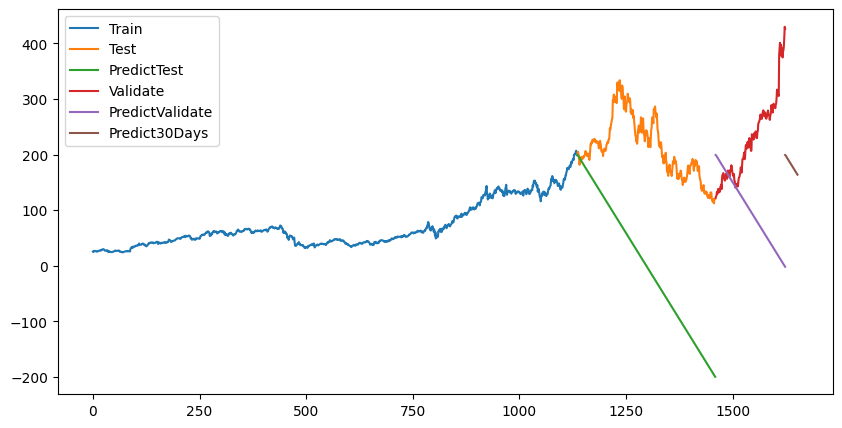

In [9]:
# 9.Vẽ hình
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_val)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'PredictTest','Validate','PredictValidate','Predict30Days'])
plt.show()

In [8]:
test_data.index

RangeIndex(start=1136, stop=1460, step=1)